# Job-A-Thon Hackathon - Credit Card Lead Prediction

# Problem Statement :
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings. The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.
Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:
Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

# Approach : 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/Data/train_data.csv")
df_train

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0
...,...,...,...,...,...,...,...,...,...,...,...
245720,BPAWWXZN,Male,51,RG284,Self_Employed,X3,109,NaN,1925586,No,0
245721,HFNB7JY8,Male,27,RG268,Salaried,X1,15,No,862952,Yes,0
245722,GEHAUCWT,Female,26,RG281,Salaried,X1,13,No,670659,No,0
245723,GE7V8SAH,Female,28,RG273,Salaried,X1,31,No,407504,No,0


## Data Preprocessing :

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


### Checking null values :

In [ ]:
df_train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [ ]:
# Percent of null values present in attribute credit_product
perc_null_creditProduct = ( df_train['Credit_Product'].isnull().sum() / df_train.size ) * 100
perc_null_creditProduct

1.0849156947437546

Only 1% of the data contains null value for attribute Credit_Product. This attribute is important in the prediction of target, so replacing null value with majority category of that feature that is 'No'.

In [ ]:
#dropin rows with null values
df_train.fillna('No', inplace = True)

In [ ]:
df_train.isnull().sum()       #Rechecking null values

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

Now no null value is present.

In [ ]:
# descriptive statistics
df_train.describe(include = 'all').round(decimals=2)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
count,245725,245725,245725.00,245725,245725,245725,245725.00,245725,245725.00,245725,245725.00
unique,245725,2,NaN,35,4,4,NaN,2,NaN,2,NaN
top,CVDX7B6G,Male,NaN,RG268,Self_Employed,X1,NaN,No,NaN,No,NaN
freq,1,134197,NaN,35934,100886,103718,NaN,173682,NaN,150290,NaN
mean,NaN,NaN,43.86,NaN,NaN,NaN,46.96,NaN,1128403.10,NaN,0.24
std,NaN,NaN,14.83,NaN,NaN,NaN,32.35,NaN,852936.36,NaN,0.43
min,NaN,NaN,23.00,NaN,NaN,NaN,7.00,NaN,20790.00,NaN,0.00
25%,NaN,NaN,30.00,NaN,NaN,NaN,20.00,NaN,604310.00,NaN,0.00
50%,NaN,NaN,43.00,NaN,NaN,NaN,32.00,NaN,894601.00,NaN,0.00
75%,NaN,NaN,54.00,NaN,NaN,NaN,73.00,NaN,1366666.00,NaN,0.00


### Checking the class imbalance:

In [ ]:
# checking class imbalance
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(df_train['Is_Lead'])

0    76.279174
1    23.720826
Name: Is_Lead, dtype: float64

This indicates imbalance in class

### Checking outliers :

In [ ]:
#function to detect outliers using IQR method
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns[:-1]:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column, 'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(df_train)

,Feature,Number of Outliers
0,Age,0
1,Vintage,0
2,Avg_Account_Balance,14612


There are outliers present in Avg_Account_Balance.

### Univariate analysis of categorical column : 

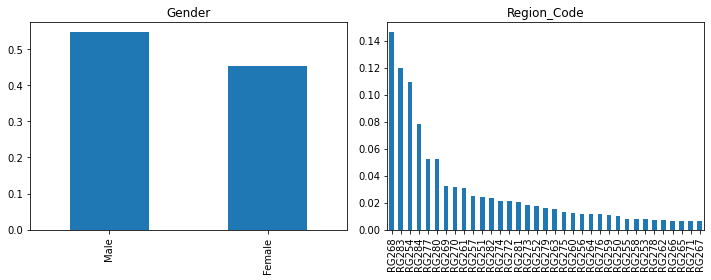

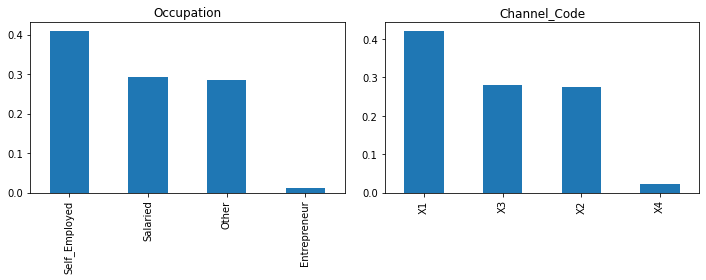

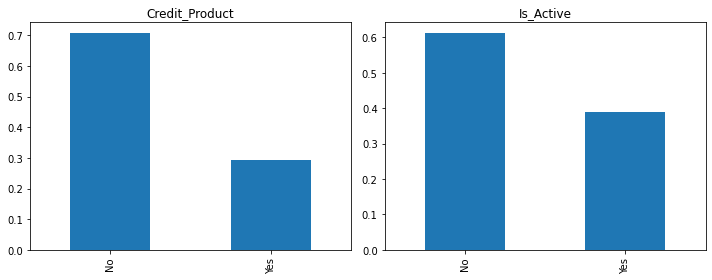

In [ ]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object']).columns[1:]
    
    for i in range(0,len(categorical_columns),2):
            if len(categorical_columns) > i+1:
                
                plt.figure(figsize=(10,4))
                plt.subplot(121)
                dataframe[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar')
                plt.title(categorical_columns[i])
                plt.subplot(122)     
                dataframe[categorical_columns[i+1]].value_counts(normalize=True).plot(kind='bar')
                plt.title(categorical_columns[i+1])
                plt.tight_layout()
                plt.show()

            else:
                dataframe[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar')
                plt.title(categorical_columns[i])
        
        
plot = plot_categorical_columns(df_train)      

Most of the customers are self employed. Most of the customers have no active credit product from bank. Most of the customers don't have active accounts since 3 months. Most of the customers are male.

### Univariate Analysis of Continuous Column :

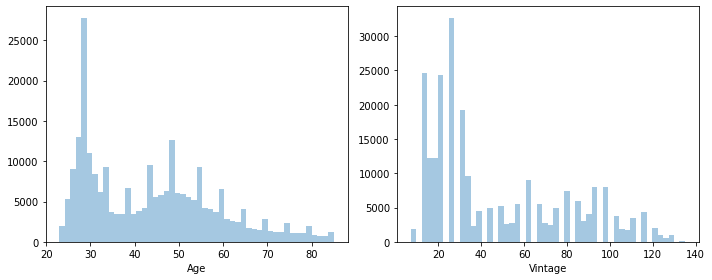

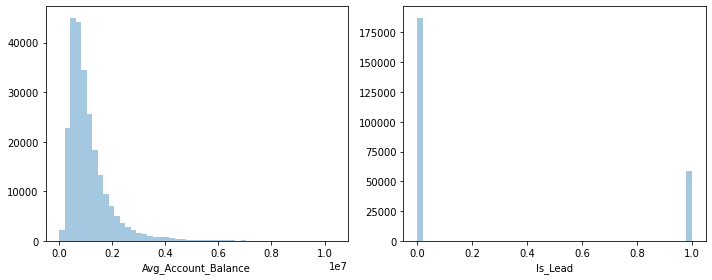

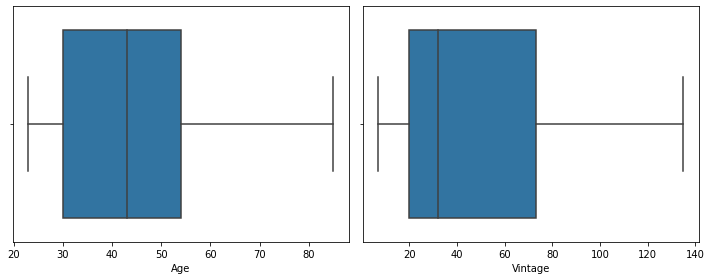

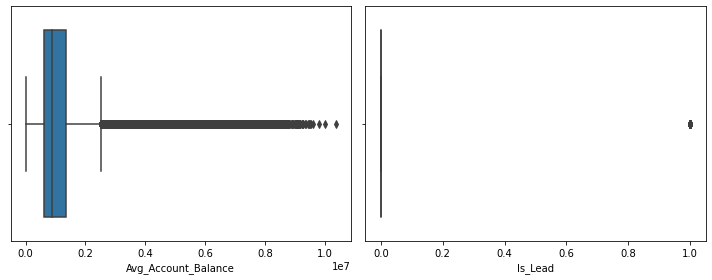

In [ ]:
# Function to plot histograms
def plot_continuous_columns(dataframe):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)            
            sns.distplot(dataframe[numeric_columns[i+1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)

# Function to plot boxplots
def plot_box_plots(dataframe):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])

    
    
    
plot_continuous_columns(df_train)            
plot_box_plots(df_train)



As we can see from histogram, the features Avg_Account_Balance is heavily skewed and this is due to the presence of outliers as seen in the boxplot for these feature.

### Bivariate Analysis of Categorical column :

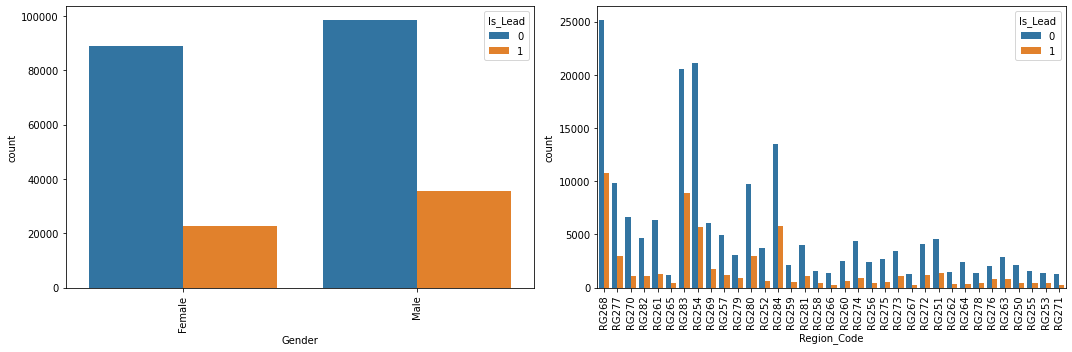

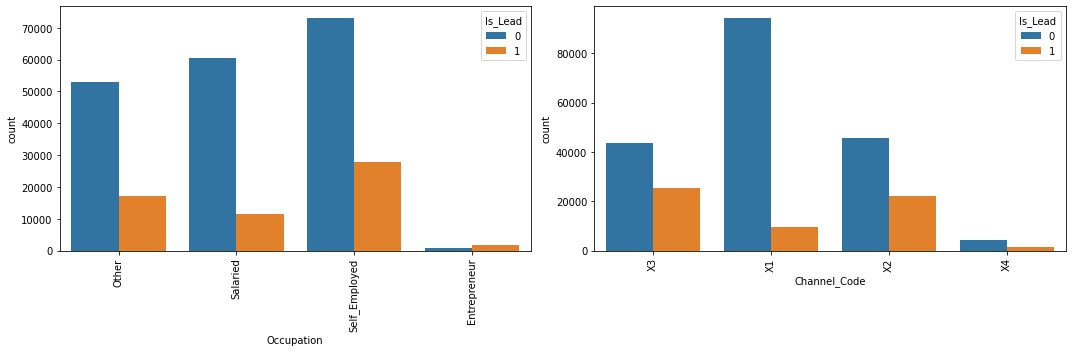

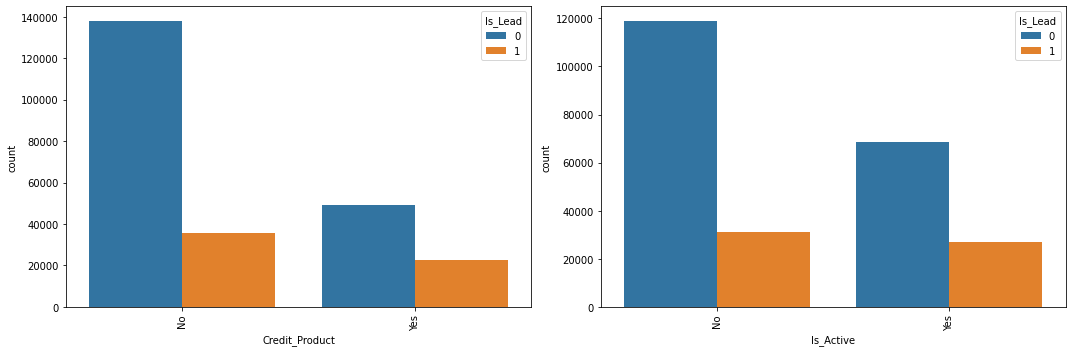

In [ ]:
def bivariate_analysis_categorical(dataframe,target):
    categorical_columns = dataframe.select_dtypes(exclude=np.number).columns[1:]
    for i in range(0,len(categorical_columns),2):
        if len(categorical_columns) > i+1:
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            sns.countplot(x=dataframe[categorical_columns[i]],hue=target,data=dataframe)
            plt.xticks(rotation=90)
            plt.subplot(122)            
            sns.countplot(dataframe[categorical_columns[i+1]],hue=target,data=dataframe)
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.show()


bivariate_analysis_categorical(df_train,df_train['Is_Lead'])

### Treating outliers using winsorization

In [ ]:
# Function to treat outliers 
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns[:-1]:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


df_train = treat_outliers(df_train)

# Checking for outliers after applying winsorization
detect_outliers(df_train)

,Feature,Number of Outliers
0,Age,0
1,Vintage,0
2,Avg_Account_Balance,0


For simplicity I am removing region_code and Channel_code feature.

In [ ]:
#dropping unrequired columns to avoid overfitting
df_train.drop(['Region_Code', 'Channel_Code'], axis = 1, inplace = True)

Before moving further let's convert categorical data into numeric data since machine learning model works only with numeric values. I am using get_dummies for feature occupation and label encoder for features gender, credit_product, is_active.

In [ ]:
#Label Encoding
label_col = ['Gender', 'Credit_Product', 'Is_Active']
for col in label_col:
  le = LabelEncoder()
  df_train[col] = le.fit_transform(df_train[col])

# create four dummy variables using get_dummies, then exclude the first dummy column
dummies = pd.get_dummies(df_train['Occupation'], prefix='Occupation').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
df_train = pd.concat([df_train, dummies], axis=1)
df_train.drop(['Occupation'], axis = 1, inplace = True)

df_train.head()

,ID,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed
0,NNVBBKZB,0,64,43,0,1045696,0,0,1,0,0
1,IDD62UNG,0,30,32,0,581988,0,0,0,1,0
2,HD3DSEMC,0,56,26,0,1484315,1,0,0,0,1
3,BF3NC7KV,1,34,19,0,470454,0,0,0,1,0
4,TEASRWXV,0,30,33,0,886787,0,0,0,1,0


In [ ]:
#Rearranging columns so that target variable comes at the end
df_train = df_train.reindex(columns=['ID', 'Gender', 'Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Occupation_Other',
                                     'Occupation_Salaried', 'Occupation_Self_Employed', 'Is_Lead'])


### Using RFE for feature selection :
I'm using Recursive Feature Elimination for selecting the best features. RFE is a wrapper method that uses the model to identify the best features.

The function feature selection takes four parameters predictors, target, model and the number_of_features. The parameter number_of_features is used for explicitly stating the number of features you want to specify inside the RFE object. For the below code, I have inputted 5 feature.

In [ ]:
# Feature Scaling
xc = MinMaxScaler()

# Predictors
x = df_train.iloc[:,1:-1]

# Target
y = df_train.iloc[:,-1]

# Scaled Features
x[['Avg_Account_Balance', 'Age', 'Vintage']] = xc.fit_transform(x[['Avg_Account_Balance', 'Age', 'Vintage']])

In [ ]:
# Function to select features using RFE
def feature_selection(predictors, target, number_of_features, model):

    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(x,y)
    feature_ranking = pd.Series(rfe.ranking_, index=x.columns)
    print('Features  to be selected for {} are:'.format(str(i[0])))
    print(feature_ranking[feature_ranking.values==1].index.tolist())
    print('===='*30)

# Choosing the models.
models = {'Logistic Regression':LogisticRegression,'Random Forest':RandomForestClassifier}

# Selecting 7 number of features
for i in models.items():
    feature_selection(x,y,7,i[1])

Features  to be selected for Logistic Regression are:
['Age', 'Vintage', 'Credit_Product', 'Is_Active', 'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed']
Features  to be selected for Random Forest are:
['Gender', 'Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Occupation_Salaried']


Using this features I have build two classifiers.

### Grid Search for Hyperparameter tuning :
Below I'm performing hyperparameter tuning using GridSearch for both the classifier. After finding out best parameters, I am building classifier using that hyperparameter on best features obtained using 
RFE method.
Since the target is imbalanced, I am applying Synthetic Minority Oversampling (SMOTE) for undersampling and oversampling the majority and minority classes in the target respectively.

In [ ]:
# Function for finding best fit parameters using grid search
def grid_search(dataframe, target, model, param_grid):

    x_train,x_val,y_train,y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)
    classifier = model()

    grid_search_model = GridSearchCV(classifier, param_grid=param_grid)
    grid_search_model.fit(x_train, y_train)
    print('Best Parameters for {} are:'.format(cls[0]))
    return grid_search_model.best_params_


In [ ]:
# applying grid search on logistic and random forest classifier
classifier_param = {'Random Forest' : [RandomForestClassifier,
  {'n_estimators' : [100,150,200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [6,7,8,9,10,12], 'criterion' :['gini', 'entropy']}],
  'Logistic Regression' : [LogisticRegression,
  {'C' : np.logspace(-5, 8, 15), 'penalty' : ['l1', 'l2', 'elasticnet'], 'max_iter' : [40,60,80,100]}]}

best_param = {}

for cls in classifier_param.items():
  best_param[cls[0]] = grid_search(x, y, cls[1][0], cls[1][1])
  print(best_param[cls[0]])

Best Parameters for Random Forest are:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 150}
Best Parameters for Logistic Regression are:
{'C': 0.4393970560760795, 'max_iter': 40, 'penalty': 'l2'}


### Random Forest Classifier :

On Validation data
ROC_AUC_SCORE is 0.8723850012871823
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     43414
           1       0.79      0.92      0.85     30304

    accuracy                           0.86     73718
   macro avg       0.86      0.87      0.86     73718
weighted avg       0.87      0.86      0.87     73718

[[35819  7595]
 [ 2433 27871]]


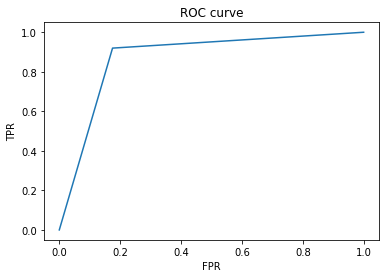

In [ ]:
# Function to build random forest classifier using parameters obtained by grid search
def random_forrest_best(dataframe,target):
    
    
    x_train, x_val, y_train, y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)
    
    # Applying Smote on train data for dealing with class imbalance
    smote = SMOTE()
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    rfc = RandomForestClassifier(n_estimators=150, max_features='auto', max_depth=10, criterion='gini',random_state=42)
    rfc.fit(X_sm, y_sm)
    y_pred = rfc.predict(x_val)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation data')
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    #plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return rfc
    
# Features are selected from rfe method above
rfc_model = random_forrest_best(x[['Gender', 'Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Occupation_Salaried']],y)

## Logistic Regression :

On Validation data
ROC_AUC_SCORE is 0.6567881915123543
              precision    recall  f1-score   support

           0       0.86      0.65      0.74     56260
           1       0.37      0.66      0.48     17458

    accuracy                           0.66     73718
   macro avg       0.62      0.66      0.61     73718
weighted avg       0.75      0.66      0.68     73718

[[36784 19476]
 [ 5940 11518]]


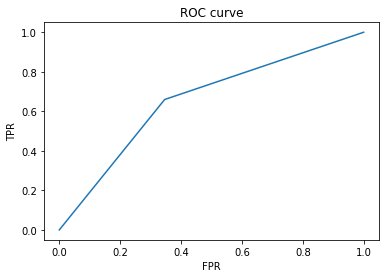

In [68]:
def log_reg_best(dataframe,target):
    
    
    x_train, x_val, y_train, y_val = train_test_split(dataframe, target, test_size=0.3, random_state=42)
    
    # Applying Smote on train data for dealing with class imbalance
    smote = SMOTE()
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    log_reg = LogisticRegression(C = 0.4393970560760795, max_iter = 60, penalty = 'l2', random_state=42)
    log_reg.fit(X_sm, y_sm)
    y_pred = log_reg.predict(x_val)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation data')
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    #plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return log_reg

log_model = log_reg_best(x[['Age','Vintage','Credit_Product','Is_Active','Occupation_Other','Occupation_Salaried','Occupation_Self_Employed']],y)

Best classifier between this two is RandomForest Classifier, So I am using that on test data to predict target class.

## Test Dataset Prediction :
Before predicting, I am applying same data preprocessing techniques as I applied to training dataset.

In [69]:
df_test = pd.read_csv("/content/drive/My Drive/Data/test_data.csv")


In [70]:
#Checking null values
df_test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

In [71]:
#dropin rows with null values
df_test.fillna('No', inplace = True)

In [72]:
#Checking outliers
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns = ['Feature', 'Number of Outliers'])
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column, 'Number of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(df_test)

,Feature,Number of Outliers
0,Age,0
1,Vintage,0
2,Avg_Account_Balance,6218


In [73]:
# treating outliers
def treat_outliers(dataframe):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(include=np.number).columns:
            dataframe[col] = winsorize(dataframe[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return dataframe    


df_test = treat_outliers(df_test)

# Checking for outliers after applying winsorization
detect_outliers(df_test)

,Feature,Number of Outliers
0,Age,0
1,Vintage,0
2,Avg_Account_Balance,0


In [74]:
#dropping unrequired columns to avoid overfitting
df_test.drop(['Region_Code', 'Channel_Code'], axis = 1, inplace = True)

In [75]:
#Label Encoding
label_col = ['Gender', 'Credit_Product', 'Is_Active']
for col in label_col:
  le = LabelEncoder()
  df_test[col] = le.fit_transform(df_test[col])

# create four dummy variables using get_dummies, then exclude the first dummy column
dummies = pd.get_dummies(df_test['Occupation'], prefix='Occupation').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)
df_test = pd.concat([df_test, dummies], axis=1)
df_test.drop(['Occupation'], axis = 1, inplace = True)

df_test.head()

,ID,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed
0,VBENBARO,1,29,25,1,742366,0,1,0,0
1,CCMEWNKY,1,43,49,0,925537,0,1,0,0
2,VK3KGA9M,1,31,14,0,356062,0,0,1,0
3,TT8RPZVC,1,29,33,0,868070,0,1,0,0
4,SHQZEYTZ,0,29,19,0,657087,0,1,0,0


In [76]:
# Predictors
x = df_test[['Gender', 'Age', 'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Occupation_Salaried']]
id = df_test[['ID']]
# Feature Scaling
xct = MinMaxScaler()

x = xct.fit_transform(x)

y_pred_test = rfc_model.predict(x)


In [77]:
predictions = pd.DataFrame(y_pred_test, columns = ['Is_Lead'])

submission = pd.concat([id, predictions['Is_Lead']], axis = 1)

submission.to_csv('submission.csv',index=False)

In [78]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>